Iteration 500: sigma_x = 0.561, sigma_y = 2.272, acceptance = 0.458
Iteration 1000: sigma_x = 0.470, sigma_y = 1.936, acceptance = 0.466
Iteration 1500: sigma_x = 0.772, sigma_y = 1.782, acceptance = 0.457
Iteration 2000: sigma_x = 1.159, sigma_y = 1.974, acceptance = 0.455
Iteration 2500: sigma_x = 0.816, sigma_y = 2.329, acceptance = 0.453
Final acceptance rate: 0.454
Estimated sigma_x: 1.010 (true: 1.000)
Estimated sigma_y: 1.711 (true: 2.000)


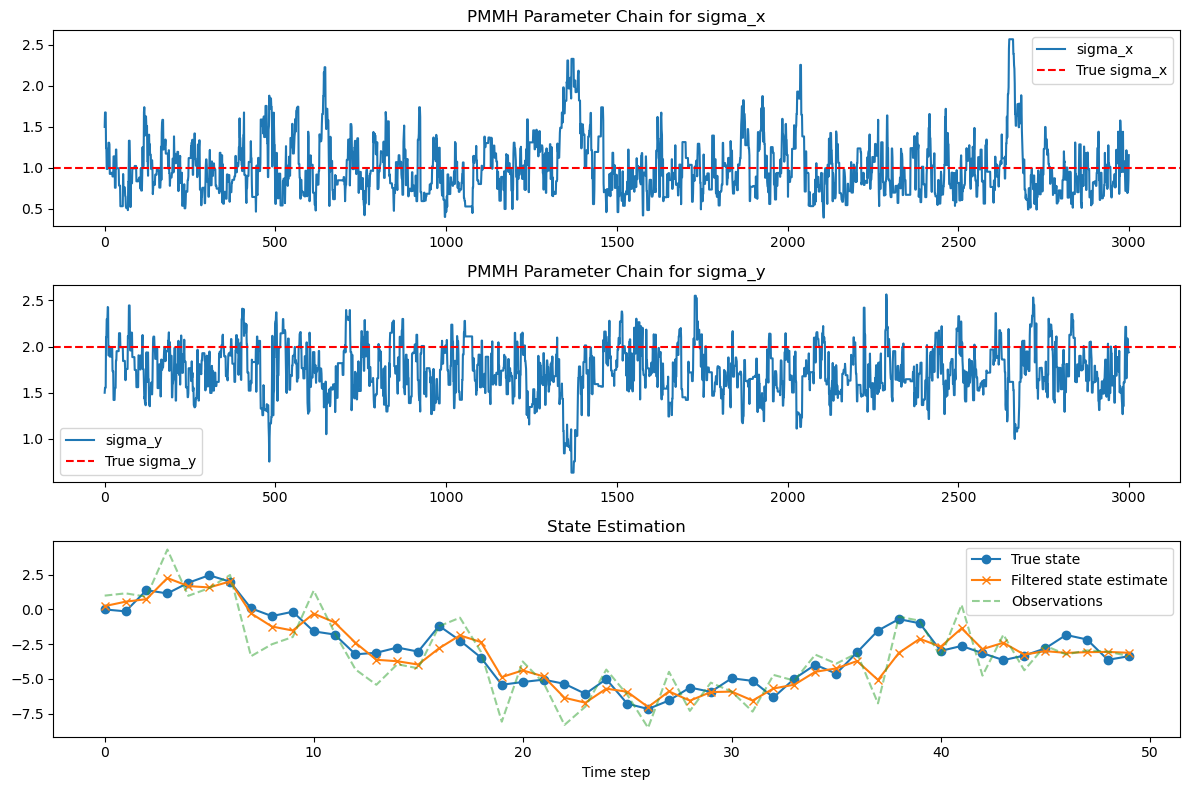

In [1]:
import numpy as np
from scipy.stats import norm, expon
import matplotlib.pyplot as plt

# ================================
# 1. Generate Synthetic Data
# ================================
np.random.seed(42)

# True parameters
true_sigma_x = 1.0   # process noise std
true_sigma_y = 2.0   # observation noise std
T = 50               # number of time steps

# Generate states and observations
x_true = np.zeros(T)
y_obs = np.zeros(T)
x_true[0] = 0.0
y_obs[0] = x_true[0] + np.random.normal(0, true_sigma_y)
for t in range(1, T):
    x_true[t] = x_true[t-1] + np.random.normal(0, true_sigma_x)
    y_obs[t] = x_true[t] + np.random.normal(0, true_sigma_y)

# ================================
# 2. Particle Filter Function
# ================================
def particle_filter(y_obs, sigma_x, sigma_y, N=500):
    """
    Runs a particle filter on the data y_obs given model parameters.
    
    Model:
      x_t = x_{t-1} + eps,   eps ~ N(0, sigma_x)
      y_t = x_t + eta,       eta ~ N(0, sigma_y)
    
    Returns:
      log_likelihood: The log likelihood estimate for the full data.
      filtered_means: The estimated state (posterior mean) at each time step.
    """
    T = len(y_obs)
    
    # Allocate arrays
    particles = np.zeros((T, N))
    weights = np.zeros((T, N))
    filtered_means = np.zeros(T)
    
    # Initialization: assume x0 ~ N(0, 1)
    particles[0, :] = np.random.normal(0, 1, size=N)
    weights[0, :] = norm.pdf(y_obs[0], loc=particles[0, :], scale=sigma_y)
    weight_sum = np.sum(weights[0, :])
    # Normalize weights
    weights[0, :] /= weight_sum
    # Log likelihood contribution at t=0
    log_likelihood = np.log(weight_sum / N)
    # Filtered estimate at t=0
    filtered_means[0] = np.sum(particles[0, :] * weights[0, :])
    
    # Loop over time steps
    for t in range(1, T):
        # Resample: draw N indices with replacement according to the previous weights
        indices = np.random.choice(N, size=N, p=weights[t-1, :])
        particles[t-1, :] = particles[t-1, indices]
        
        # Propagate particles through the state equation
        particles[t, :] = particles[t-1, :] + np.random.normal(0, sigma_x, size=N)
        
        # Weight particles using the observation likelihood
        weights[t, :] = norm.pdf(y_obs[t], loc=particles[t, :], scale=sigma_y)
        weight_sum = np.sum(weights[t, :])
        # Avoid division by zero (in practice, use adaptive methods if weight_sum==0)
        if weight_sum == 0:
            weights[t, :] = np.ones(N) / N
        else:
            weights[t, :] /= weight_sum
        
        # Update log likelihood (using the average unnormalized weight)
        log_likelihood += np.log(weight_sum / N)
        # Filtered state estimate (posterior mean) at time t
        filtered_means[t] = np.sum(particles[t, :] * weights[t, :])
    
    return log_likelihood, filtered_means

# ================================
# 3. PMMH to Estimate Parameters
# ================================
def PMMH(y_obs, n_iter=3000, N=500):
    """
    Particle Marginal Metropolis-Hastings (PMMH) algorithm to estimate 
    sigma_x and sigma_y (the standard deviations, not the variances)
    for the state space model.
    
    We use Exponential(1) priors on sigma_x and sigma_y.
    """
    # Storage for parameters and likelihoods
    sigma_x_samples = np.zeros(n_iter)
    sigma_y_samples = np.zeros(n_iter)
    loglikelihoods = np.zeros(n_iter)
    
    # Initialize parameters (start with some positive numbers)
    sigma_x_current = 1.5
    sigma_y_current = 1.5
    ll_current, _ = particle_filter(y_obs, sigma_x_current, sigma_y_current, N)
    
    sigma_x_samples[0] = sigma_x_current
    sigma_y_samples[0] = sigma_y_current
    loglikelihoods[0] = ll_current
    
    # Tuning: proposal standard deviations for sigma_x and sigma_y (on the positive real line)
    prop_std_x = 0.3
    prop_std_y = 0.3
    
    # PMMH iterations
    accept_count = 0
    for i in range(1, n_iter):
        # Propose new parameters (using a random walk on the positive reals)
        sigma_x_proposal = sigma_x_current + np.random.normal(0, prop_std_x)
        sigma_y_proposal = sigma_y_current + np.random.normal(0, prop_std_y)
        
        # Reject proposals that are not positive
        if sigma_x_proposal <= 0 or sigma_y_proposal <= 0:
            sigma_x_samples[i] = sigma_x_current
            sigma_y_samples[i] = sigma_y_current
            loglikelihoods[i] = ll_current
            continue
        
        # Run particle filter for proposed parameters
        ll_proposal, _ = particle_filter(y_obs, sigma_x_proposal, sigma_y_proposal, N)
        
        # Prior densities: here we use Exponential(1) for each sigma (density = exp(-sigma) for sigma > 0)
        # prior_current = np.exp(-sigma_x_current) * np.exp(-sigma_y_current)
        # prior_proposal = np.exp(-sigma_x_proposal) * np.exp(-sigma_y_proposal)
        prior_current = 1
        prior_proposal = 1
        
        # Compute acceptance probability (symmetric proposal so proposal densities cancel)
        log_alpha = (ll_proposal + np.log(prior_proposal)) - (ll_current + np.log(prior_current))
        if np.log(np.random.rand()) < log_alpha:
            # Accept the proposal
            sigma_x_current = sigma_x_proposal
            sigma_y_current = sigma_y_proposal
            ll_current = ll_proposal
            accept_count += 1
        
        sigma_x_samples[i] = sigma_x_current
        sigma_y_samples[i] = sigma_y_current
        loglikelihoods[i] = ll_current
        
        if i % 500 == 0:
            print(f"Iteration {i}: sigma_x = {sigma_x_current:.3f}, sigma_y = {sigma_y_current:.3f}, acceptance = {accept_count/i:.3f}")
            
    print(f"Final acceptance rate: {accept_count/n_iter:.3f}")
    return sigma_x_samples, sigma_y_samples, loglikelihoods

# Run PMMH
n_iter = 3000
sigma_x_chain, sigma_y_chain, ll_chain = PMMH(y_obs, n_iter=n_iter, N=500)

# Discard burn-in (say first 1000 iterations)
burn_in = 1000
est_sigma_x = np.mean(sigma_x_chain[burn_in:])
est_sigma_y = np.mean(sigma_y_chain[burn_in:])
print(f"Estimated sigma_x: {est_sigma_x:.3f} (true: {true_sigma_x:.3f})")
print(f"Estimated sigma_y: {est_sigma_y:.3f} (true: {true_sigma_y:.3f})")

# ================================
# 4. Obtain State Estimates using the Filter
# ================================
# Use the posterior mean estimates of sigma_x and sigma_y to run the filter one final time.
ll_final, state_estimates = particle_filter(y_obs, est_sigma_x, est_sigma_y, N=1000)

# ================================
# 5. Plotting the Results
# ================================
plt.figure(figsize=(12, 8))

# Plot parameter chains
plt.subplot(3, 1, 1)
plt.plot(sigma_x_chain, label='sigma_x')
plt.axhline(true_sigma_x, color='red', linestyle='--', label='True sigma_x')
plt.legend()
plt.title('PMMH Parameter Chain for sigma_x')

plt.subplot(3, 1, 2)
plt.plot(sigma_y_chain, label='sigma_y')
plt.axhline(true_sigma_y, color='red', linestyle='--', label='True sigma_y')
plt.legend()
plt.title('PMMH Parameter Chain for sigma_y')

# Plot state estimates vs. true states and observations
plt.subplot(3, 1, 3)
plt.plot(x_true, label='True state', marker='o')
plt.plot(state_estimates, label='Filtered state estimate', marker='x')
plt.plot(y_obs, label='Observations', linestyle='--', alpha=0.5)
plt.legend()
plt.title('State Estimation')
plt.xlabel('Time step')

plt.tight_layout()
plt.show()


Iteration 500: sigma_x = 1.228, sigma_y = 1.716, skew = -0.096, acceptance = 0.442
Iteration 1000: sigma_x = 1.249, sigma_y = 1.636, skew = 0.082, acceptance = 0.474
Iteration 1500: sigma_x = 1.042, sigma_y = 1.859, skew = -0.124, acceptance = 0.460
Iteration 2000: sigma_x = 1.075, sigma_y = 1.760, skew = -0.235, acceptance = 0.475
Iteration 2500: sigma_x = 0.984, sigma_y = 1.661, skew = -0.130, acceptance = 0.474
Iteration 3000: sigma_x = 0.763, sigma_y = 1.759, skew = -0.293, acceptance = 0.483
Iteration 3500: sigma_x = 0.877, sigma_y = 1.491, skew = -0.311, acceptance = 0.479
Iteration 4000: sigma_x = 1.537, sigma_y = 1.759, skew = -0.189, acceptance = 0.483
Iteration 4500: sigma_x = 1.133, sigma_y = 1.701, skew = -0.222, acceptance = 0.486
Iteration 5000: sigma_x = 1.121, sigma_y = 1.674, skew = -0.227, acceptance = 0.490
Iteration 5500: sigma_x = 0.889, sigma_y = 1.731, skew = -0.166, acceptance = 0.488
Iteration 6000: sigma_x = 0.970, sigma_y = 1.832, skew = -0.174, acceptance = 

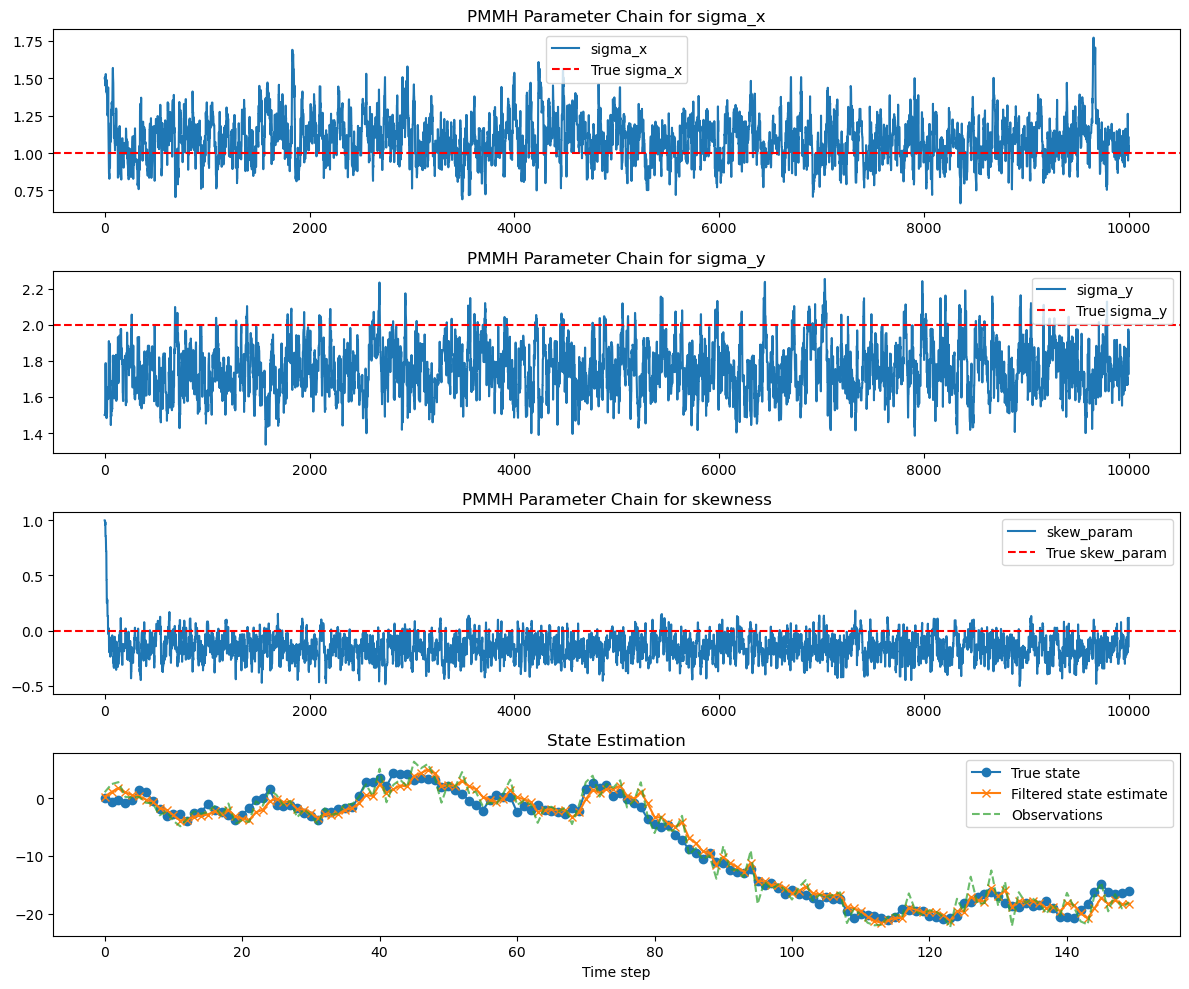

In [1]:
import numpy as np
from scipy.stats import norm, skewnorm
import matplotlib.pyplot as plt

# ================================
# 1. Generate Synthetic Data with Skewed Process Noise
# ================================
np.random.seed(42)

# True parameters
true_sigma_x = 1.0      # process noise scale (std)
true_sigma_y = 2.0      # observation noise std
true_skew_param = 0.0   # true skewness parameter for process noise
T = 150                  # number of time steps

# Generate states and observations
x_true = np.zeros(T)
y_obs = np.zeros(T)
x_true[0] = 0.0
y_obs[0] = x_true[0] + np.random.normal(0, true_sigma_y)
for t in range(1, T):
    # Process noise is skew-normal with true_skew_param
    x_true[t] = x_true[t-1] + skewnorm.rvs(a=true_skew_param, loc=0, scale=true_sigma_x)
    y_obs[t] = x_true[t] + np.random.normal(0, true_sigma_y)

# ================================
# 2. Particle Filter Function with Skewed Process Noise
# ================================
def particle_filter(y_obs, sigma_x, sigma_y, skew_param, N=500):
    """
    Runs a particle filter on the data y_obs given model parameters.
    
    Model:
      x_t = x_{t-1} + eps,   eps ~ SkewNormal(a=skew_param, loc=0, scale=sigma_x)
      y_t = x_t + eta,       eta ~ N(0, sigma_y)
    
    Returns:
      log_likelihood: The log likelihood estimate for the full data.
      filtered_means: The estimated state (posterior mean) at each time step.
    """
    T = len(y_obs)
    particles = np.zeros((T, N))
    weights = np.zeros((T, N))
    filtered_means = np.zeros(T)
    
    # Initialization: assume x0 ~ N(0, 1)
    particles[0, :] = np.random.normal(0, 1, size=N)
    weights[0, :] = norm.pdf(y_obs[0], loc=particles[0, :], scale=sigma_y)
    weight_sum = np.sum(weights[0, :])
    weights[0, :] /= weight_sum
    log_likelihood = np.log(weight_sum / N)
    filtered_means[0] = np.sum(particles[0, :] * weights[0, :])
    
    for t in range(1, T):
        # Resample indices according to previous weights
        indices = np.random.choice(N, size=N, p=weights[t-1, :])
        particles[t-1, :] = particles[t-1, :][indices]
        # Propagate particles using skew-normal process noise
        particles[t, :] = particles[t-1, :] + skewnorm.rvs(a=skew_param, loc=0, scale=sigma_x, size=N)
        # Weight using the Gaussian observation likelihood
        weights[t, :] = norm.pdf(y_obs[t], loc=particles[t, :], scale=sigma_y)
        weight_sum = np.sum(weights[t, :])
        if weight_sum == 0:
            weights[t, :] = np.ones(N) / N
        else:
            weights[t, :] /= weight_sum
        log_likelihood += np.log(weight_sum / N)
        filtered_means[t] = np.sum(particles[t, :] * weights[t, :])
        
    return log_likelihood, filtered_means

# ================================
# 3. PMMH to Estimate (sigma_x, sigma_y, skew_param)
# ================================
def PMMH(y_obs, n_iter=3000, N=500):
    """
    Particle Marginal Metropolis-Hastings (PMMH) algorithm to estimate
    sigma_x, sigma_y, and skew_param.
    
    Priors:
      sigma_x ~ Exponential(1)   (density ∝ exp(-sigma_x), sigma_x > 0)
      sigma_y ~ Exponential(1)   (density ∝ exp(-sigma_y), sigma_y > 0)
      skew_param ~ Normal(0, 10²)  (density given by norm.pdf(skew_param, 0, 10))
    """
    # Storage for parameter samples and likelihoods
    sigma_x_samples = np.zeros(n_iter)
    sigma_y_samples = np.zeros(n_iter)
    skew_samples    = np.zeros(n_iter)
    loglikelihoods  = np.zeros(n_iter)
    
    # Initialize parameters
    sigma_x_current = 1.5
    sigma_y_current = 1.5
    skew_current    = 1.0  # initial guess for skewness
    ll_current, _ = particle_filter(y_obs, sigma_x_current, sigma_y_current, skew_current, N)
    
    sigma_x_samples[0] = sigma_x_current
    sigma_y_samples[0] = sigma_y_current
    skew_samples[0]    = skew_current
    loglikelihoods[0]  = ll_current
    
    # Proposal standard deviations for random-walk updates
    prop_std_x = 0.1
    prop_std_y = 0.1
    prop_std_skew = 0.1
    
    accept_count = 0
    for i in range(1, n_iter):
        # Propose new parameters
        sigma_x_proposal = sigma_x_current + np.random.normal(0, prop_std_x)
        sigma_y_proposal = sigma_y_current + np.random.normal(0, prop_std_y)
        skew_proposal    = skew_current    + np.random.normal(0, prop_std_skew)
        
        # Reject proposals that are not positive for sigma_x or sigma_y
        if sigma_x_proposal <= 0 or sigma_y_proposal <= 0:
            sigma_x_samples[i] = sigma_x_current
            sigma_y_samples[i] = sigma_y_current
            skew_samples[i]    = skew_current
            loglikelihoods[i]  = ll_current
            continue
        
        # Run particle filter for the proposed parameters
        ll_proposal, _ = particle_filter(y_obs, sigma_x_proposal, sigma_y_proposal, skew_proposal, N)
        
        # Compute log priors:
        # For sigma_x and sigma_y: log(exp(-sigma)) = -sigma.
        # For skew_param: use norm.logpdf(skew, 0, 10).
        # log_prior_current = - sigma_x_current - sigma_y_current + norm.logpdf(skew_current, 0, 10)
        # log_prior_proposal = - sigma_x_proposal - sigma_y_proposal + norm.logpdf(skew_proposal, 0, 10)
        log_prior_current = 1
        log_prior_proposal = 1
        
        # Compute the log acceptance ratio
        log_alpha = (ll_proposal + log_prior_proposal) - (ll_current + log_prior_current)
        if np.log(np.random.rand()) < log_alpha:
            sigma_x_current = sigma_x_proposal
            sigma_y_current = sigma_y_proposal
            skew_current    = skew_proposal
            ll_current      = ll_proposal
            accept_count   += 1
        
        sigma_x_samples[i] = sigma_x_current
        sigma_y_samples[i] = sigma_y_current
        skew_samples[i]    = skew_current
        loglikelihoods[i]  = ll_current
        
        if i % 500 == 0:
            print(f"Iteration {i}: sigma_x = {sigma_x_current:.3f}, sigma_y = {sigma_y_current:.3f}, skew = {skew_current:.3f}, acceptance = {accept_count/i:.3f}")
    
    print(f"Final acceptance rate: {accept_count/n_iter:.3f}")
    return sigma_x_samples, sigma_y_samples, skew_samples, loglikelihoods

# Run PMMH
n_iter = 10000
sigma_x_chain, sigma_y_chain, skew_chain, ll_chain = PMMH(y_obs, n_iter=n_iter, N=2000)

# Discard burn-in (e.g., first 1000 iterations)
burn_in = 5000
est_sigma_x = np.mean(sigma_x_chain[burn_in:])
est_sigma_y = np.mean(sigma_y_chain[burn_in:])
est_skew    = np.mean(skew_chain[burn_in:])

print(f"Estimated sigma_x: {est_sigma_x:.3f} (true: {true_sigma_x:.3f})")
print(f"Estimated sigma_y: {est_sigma_y:.3f} (true: {true_sigma_y:.3f})")
print(f"Estimated skew:    {est_skew:.3f} (true: {true_skew_param:.3f})")

# ================================
# 4. Obtain State Estimates using the Filter
# ================================
ll_final, state_estimates = particle_filter(y_obs, est_sigma_x, est_sigma_y, est_skew, N=2000)

# ================================
# 5. Plotting the Results
# ================================
plt.figure(figsize=(12, 10))

# Parameter chains
plt.subplot(4, 1, 1)
plt.plot(sigma_x_chain, label='sigma_x')
plt.axhline(true_sigma_x, color='red', linestyle='--', label='True sigma_x')
plt.legend()
plt.title('PMMH Parameter Chain for sigma_x')

plt.subplot(4, 1, 2)
plt.plot(sigma_y_chain, label='sigma_y')
plt.axhline(true_sigma_y, color='red', linestyle='--', label='True sigma_y')
plt.legend()
plt.title('PMMH Parameter Chain for sigma_y')

plt.subplot(4, 1, 3)
plt.plot(skew_chain, label='skew_param')
plt.axhline(true_skew_param, color='red', linestyle='--', label='True skew_param')
plt.legend()
plt.title('PMMH Parameter Chain for skewness')

# State estimates vs. true st
